In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import jax.numpy as jnp
from jax import jacfwd
from scipy.optimize import minimize
from collections import namedtuple

In [2]:
Params = namedtuple('Params', [
    'm',        # [kg]      boat mass
    'g',        # [m/s2]    gravity
    'rho_w',    # [kg/m3]   water density
    'rho_a',    # [kg/m3]   air density
    'GM',       # [m]       transverse metacentric height
    'I_xx',     # [kg/m2]   xx moment of inertia
    'I_zz',     # [kg/m2]   zz moment of inertia
    'I_xz',     # [kg/m2]   xz moment of inertia
    'X_du',     # [kg]      added mass due to x' acceleration
    'Y_dv',     # [kg]      added mass due to y' acceleration
    'Y_dp',     # [kg/m]    added mass due to x' angular acceleration
    'Y_dr',     # [kg/m]    added mass due to z' angular acceleration
    'K_dr',     # [kg/m]    ???
    'K_dp',     # [kg/m]    ???
    'N_dr',     # [kg/m]    ???
    'delta',    # [m3]      volume displacement
    'A_s',      # [m2]      sail area
    'A_k',      # [m2]      keel area
    'A_r',      # [m2]      rudder area
    'l1',       # [m]       distance from CoM to sail
    'l2',       # [m]       distance from CoM to rudder
    'l3',       # [m]       ???
    'l4',       # [m]       ???
    'h1',       # [m]       ???
    'h2',       # [m]       ???
    'h3',       # [m]       ???
    'dl11',     # [kg m/s]  ???
    'dl22',     # [kg m/s]  ???
    'dl44'      # [kg m/s]  ???
])

Env:
- u_c      # [m/s]     current velocity in x direction
- v_c      # [m/s]     current velocity in y direction
- u_w      # [m/s]     wind velocity in x direction
- v_w      # [m/s]     wind velocity in y direction

Control:
- sailangle
- rudderangle

State:
- lon
- lat
- roll
- yaw
- u
- v
- rollrate
- yawrate

In [3]:
def calc_ang(vel):
    ''' angle of velocity vector '''
    u, v = vel
    ang = jnp.arctan2(v, u)
    return ang

In [4]:
def calc_J(roll, yaw):
    ''' 3d transformation matrix from body to inertial frame '''
    J = jnp.array([[jnp.cos(yaw), -jnp.sin(yaw)*jnp.cos(roll), 0, 0            ],
                   [jnp.sin(yaw),  jnp.cos(yaw)*jnp.cos(roll), 0, 0            ],
                   [0,             0,                          1, 0            ],
                   [0,             0,                          0, jnp.cos(roll)]])
    return J


def calc_vel_bc(vel_b, vel_c, J_2d):
    ''' velocity of the boat relative to the water current '''
    vel_bc = vel_b - J_2d.T @ vel_c
    return vel_bc


def calc_vel_ws(p:Params, vel_w, vel_b, rollrate, yawrate, sailangle, J_2d):
    ''' velocity of the wind relative to the sail '''
    
    vel_ws = J_2d.T @ vel_w - vel_b \
             - jnp.array([yawrate*p.l2*jnp.sin(sailangle), -yawrate*(p.l1 + p.l2*jnp.cos(sailangle) + rollrate*p.h1)])
    return vel_ws


def calc_vel_ck(p:Params, vel_bc, rollrate, yawrate):
    ''' velocity of the water current relative to the keel '''
    vel_ck = -vel_bc - jnp.array([0, -yawrate*p.l3 - rollrate*p.h2])
    return vel_ck


def calc_vel_cr(p:Params, vel_bc, rollrate, yawrate):
    ''' velocity of the water current relative to the rudder '''
    vel_cr = -vel_bc - jnp.array([0, -yawrate*p.l4 - rollrate*p.h3])
    return vel_cr


def calc_sail_alpha(sailangle, ang_ws):
    ''' Angle of attack of the sail '''
    sail_alpha = ang_ws - sailangle + np.pi
    return sail_alpha


def calc_keel_alpha(ang_ck):
    ''' Angle of attack of the keel '''
    keel_alpha = -ang_ck + np.pi
    return keel_alpha


def calc_rudder_alpha(rudderangle, ang_cr):
    ''' Angle of attack of the rudder '''
    rudder_alpha = -ang_cr + rudderangle + np.pi
    return rudder_alpha


def calc_sail_Cl(alpha):
    sail_Cl = 0.5 #! dummy value
    return sail_Cl


def calc_sail_Cd(alpha):
    sail_Cd = 0.1 #! dummy value
    return sail_Cd


def calc_keel_Cl(alpha):
    keel_Cl = 0.5 #! dummy value
    return keel_Cl


def calc_keel_Cd(alpha):
    keel_Cd = 0.1 #! dummy value
    return keel_Cd


def calc_rudder_Cl(alpha):
    rudder_Cl = 0.5 #! dummy value
    return rudder_Cl


def calc_rudder_Cd(alpha):
    rudder_Cd = 0.1 #! dummy value
    return rudder_Cd

In [5]:
def calc_M_rb(p:Params):
    ''' rigid body mass matrix '''
    M_rb = jnp.array([[p.m, 0,    0,       0     ],
                      [0,   p.m,  0,       0     ],
                      [0,   0,    p.I_xx, -p.I_xz],
                      [0,   0,   -p.I_xz,  p.I_zz]])
    return M_rb


def calc_M_a(p:Params):
    ''' added mass matrix '''
    M_a = jnp.array([[p.X_du, 0,      0,      0     ],
                     [0,      p.Y_dv, p.Y_dp, p.Y_dr],
                     [0,      p.Y_dp, p.K_dp, p.K_dr],
                     [0,      p.Y_dr, p.K_dr, p.N_dr]])
    return M_a


def calc_C_rb(p:Params, yawrate):
    ''' rigid body Coriolis matrix '''
    C_rb = jnp.array([[0,           -p.m*yawrate, 0, 0],
                      [p.m*yawrate,  0,           0, 0],
                      [0,            0,           0, 0],
                      [0,            0,           0, 0]])
    return C_rb


def calc_C_a(p:Params, rollrate, yawrate, vel_bc):
    ''' added mass Coriolis matrix '''
    u_bc, v_bc = vel_bc
    C_a = jnp.array([[ 0,                                              0,           0,  p.Y_dv*v_bc + p.Y_dp*rollrate + p.Y_dr*yawrate],
                     [ 0,                                              0,           0, -p.X_du*u_bc                                   ],
                     [ 0,                                              0,           0,  0                                             ],
                     [-p.Y_dv*v_bc - p.Y_dp*rollrate - p.Y_dr*yawrate, p.X_du*u_bc, 0,  0                                             ]])
    return C_a


def calc_D_l(p:Params):
    ''' linear damping matrix '''
    D_l = jnp.array([[p.dl11, 0,      0,      0],
                     [0,      p.dl22, 0,      0],
                     [0,      0,      0,      0],
                     [0,      0,      0, p.dl44]])
    return D_l


def calc_g(p:Params, roll):
    ''' restoring forces '''
    g = jnp.array([0, 0, p.rho_w * p.g * p.delta * p.GM * jnp.sin(roll) * jnp.cos(roll), 0])
    return g


def calc_S(p:Params, vel_ws, sailangle):
    ang_ws = calc_ang(vel_ws)
    sail_alpha = calc_sail_alpha(sailangle, ang_ws)

    sail_Cl = calc_sail_Cl(sail_alpha)
    sail_Cd = calc_sail_Cd(sail_alpha)

    S_l = 0.5 * p.rho_a * p.A_s * sail_Cl * jnp.hypot(*vel_ws)**2
    S_d = 0.5 * p.rho_a * p.A_s * sail_Cd * jnp.hypot(*vel_ws)**2

    S1 = -S_l*jnp.sin(ang_ws) + S_d*jnp.cos(ang_ws)
    S2 = S_l*jnp.cos(ang_ws) + S_d*jnp.sin(ang_ws)
    S3 = p.h1*S2
    S4 = S1*p.l2*jnp.sin(sailangle) - S2*(p.l1 + p.l2*jnp.cos(sailangle))

    S = jnp.array([S1, S2, S3, S4])
    return S


def calc_K(p:Params, vel_ck):
    ang_ck = calc_ang(vel_ck)
    keel_alpha = calc_keel_alpha(ang_ck)

    keel_Cl = calc_keel_Cl(keel_alpha)
    keel_Cd = calc_keel_Cd(keel_alpha)

    K_l = 0.5 * p.rho_w * p.A_k * keel_Cl * jnp.hypot(*vel_ck)**2
    K_d = 0.5 * p.rho_w * p.A_k * keel_Cd * jnp.hypot(*vel_ck)**2

    K1 = K_l*jnp.sin(ang_ck) + K_d*jnp.cos(ang_ck)
    K2 = -K_l*jnp.cos(ang_ck) + K_d*jnp.sin(ang_ck)
    K3 = -p.h2*K2
    K4 = p.l3*K3

    K = jnp.array([K1, K2, K3, K4])
    return K


def calc_R(p:Params, vel_cr, rudderangle):
    ang_cr = calc_ang(vel_cr)
    rudder_alpha = calc_rudder_alpha(rudderangle, ang_cr)

    rudder_Cl = calc_rudder_Cl(rudder_alpha)
    rudder_Cd = calc_rudder_Cd(rudder_alpha)

    R_l = 0.5 * p.rho_w * p.A_r * rudder_Cl * jnp.hypot(*vel_cr)**2
    R_d = 0.5 * p.rho_w * p.A_r * rudder_Cd * jnp.hypot(*vel_cr)**2

    R1 = R_l*jnp.sin(ang_cr) + R_d*jnp.cos(ang_cr)
    R2 = -R_l*jnp.cos(ang_cr) + R_d*jnp.sin(ang_cr)
    R3 = -p.h3*R2
    R4 = p.l4*R3

    R = jnp.array([R1, R2, R3, R4])
    return R

In [27]:
def dynamics(p:Params, environment, state, control):
    u_c, v_c, u_w, v_w = environment
    vel_c = environment[0:2]
    vel_w = environment[2:4]
    
    x, y, roll, yaw, u, v, rollrate, yawrate = state
    vel_b = state[4:6]
    pos_array = state[0:4]
    vel_array = state[4:8]
    
    sailangle, rudderangle = control

    J = calc_J(roll, yaw)
    J_2d = J[0:2, 0:2]
    vel_bc = calc_vel_bc(vel_b, vel_c, J_2d)
    vel_bc_array = jnp.array([vel_bc[0], vel_bc[1], rollrate, yawrate])
    vel_ws = calc_vel_ws(p, vel_w, vel_b, rollrate, yawrate, sailangle, J_2d)
    vel_ck = calc_vel_ck(p, vel_bc, rollrate, yawrate)
    vel_cr = calc_vel_cr(p, vel_bc, rollrate, yawrate)

    M_rb = calc_M_rb(p)
    M_a = calc_M_a(p)
    C_rb = calc_C_rb(p, yawrate)
    C_a = calc_C_a(p, rollrate, yawrate, vel_bc)
    D_l = calc_D_l(p)
    g = calc_g(p, roll)
    S = calc_S(p, vel_ws, sailangle)
    K = calc_K(p, vel_ck)
    R = calc_R(p, vel_cr, rudderangle)

    state_dot = jnp.concat([J@vel_array,
                            jnp.linalg.inv(M_rb + M_a) @ (K + R - C_rb@vel_array - C_a@vel_bc_array - D_l@vel_bc_array - g)])

    # state_dot = jnp.concat([J@vel_array,
    #                         jnp.linalg.inv(M_rb + M_a) @ (S + K + R - C_rb@vel_array - C_a@vel_bc_array - D_l@vel_bc_array - g)])
    return state_dot

In [28]:
def rk4(p:Params, environment, state, control, dt):
    """ Runge-Kutta (4th order) explicit integration. """
    k1 = dt*dynamics(p, environment, state, control)
    k2 = dt*dynamics(p, environment, state + k1/2, control)
    k3 = dt*dynamics(p, environment, state + k2/2, control)
    k4 = dt*dynamics(p, environment, state + k3, control)

    state_next = state + (k1 + 2*k2 + 2*k3 + k4)/6
    # x_next[3] = wrap2pi(x_next[3])
    
    return state_next


def hermite_simpson(p:Params, environment, state1, state2, control, dt):
    """ Hermite-Simpson implicit integration. """
    state1_dot = dynamics(p, environment, state1, control)
    state2_dot = dynamics(p, environment, state2, control)

    state_mid = (state1 + state2)/2 + dt*(state1_dot - state2_dot)/8

    return state1 + dt*(state1_dot + 4*dynamics(p, environment, state_mid, control) + state2_dot)/6 - state2

In [29]:
def plot_boat(ax, state, control):
    p = [0.03, 40, 6000, 200, 1500, 0.5, 0.5, 2, 300, 400, 0.2]
    x, y, roll, yaw, u, v, rollrate, yawrate = state
    sailangle, rudderangle = control
    
    k1 = 0.4 # boat width scale factor
    k3 = 0.3 # rudder scale factor

    points = np.array([[x + (p[5]+p[6])*np.cos(yaw), y + (p[5]+p[6])*np.sin(yaw)],
                        [x + k1*p[6]*np.sin(yaw) + p[5]*np.cos(yaw), y - k1*p[6]*np.cos(yaw) + p[5]*np.sin(yaw)],
                        [x + k1*p[6]*np.sin(yaw) - p[6]*np.cos(yaw), y - k1*p[6]*np.cos(yaw) - p[6]*np.sin(yaw)],
                        [x - k1*p[6]*np.sin(yaw) - p[6]*np.cos(yaw), y + k1*p[6]*np.cos(yaw) - p[6]*np.sin(yaw)],
                        [x - k1*p[6]*np.sin(yaw) + p[5]*np.cos(yaw), y + k1*p[6]*np.cos(yaw) + p[5]*np.sin(yaw)]])

    ax.fill(points[:,0], points[:,1], color='k', alpha=0.2) # boat
    ax.arrow(x-p[6]*np.cos(yaw), y-p[6]*np.sin(yaw), -k3*p[6]*np.cos(yaw+rudderangle), -k3*p[6]*np.sin(yaw+rudderangle)) # rudder
    ax.arrow(x+p[5]*np.cos(yaw), y+p[5]*np.sin(yaw), -2*p[5]*np.cos(yaw+sailangle), -2*p[5]*np.sin(yaw+sailangle)) # sail


def plot_wind(ax, environment):
    u_c, v_c, u_w, v_w = environment

    xs,ys = np.meshgrid(np.linspace(-20,20,20), np.linspace(-20,20,20))
    xs,ys = xs.flatten(),ys.flatten()
    us = u_w*np.ones(xs.shape)
    vs = v_w*np.ones(xs.shape)

    ax.quiver(xs, ys, us, vs, linewidth=0.05, color='#A23BEC') 

In [30]:
params = Params(m=1600, g=9.81, rho_w=1020, rho_a=1.23, GM=2.4,
                I_xx=6.8e3, I_zz=8.5e3, I_xz=-13.4,
                X_du=-1.62e2, Y_dv=-1.2e3, Y_dp=0, Y_dr=-3.5e2, K_dr=0, K_dp=-1.0e3, N_dr=-2.4e3,
                delta = 1600/1020, A_s=23.8, A_k=0.93, A_r=0.30,
                l1=-1.82, l2=1.35, l3=-0.66, l4=3.7, h1=5.2, h2=0.95, h3=0.7,
                dl11=10, dl22=16, dl44=40)

state = jnp.array([0.0, 0.0, 0.0, np.pi/2,
                   1.0, 0.0, 0.001*np.random.randn(), 0.001*np.random.randn()], dtype=np.float32)
env = jnp.array([0,0, 0.0, 0.0], dtype=np.float32)
control = jnp.array([0.0, 0.0], dtype=np.float32)

In [31]:
N = 100
dt = 0.05

X = np.zeros((N, 8))
X[0] = state

U = np.zeros((N, 2))

for k in range(N-1):
    U[k] = control
    X[k+1] = rk4(params, env, X[k], U[k], dt)

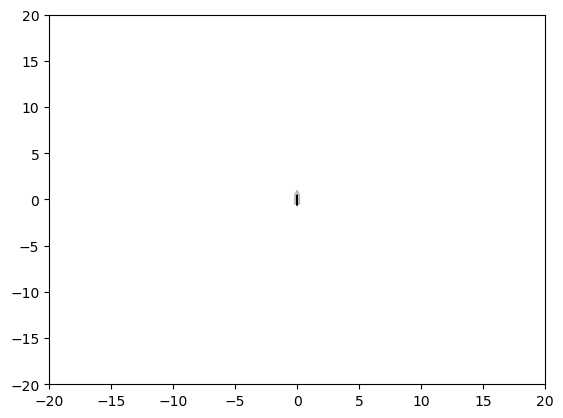

In [32]:
fig, ax = plt.subplots()

def func(k):
    global state
    ax.cla()
    # plot_wind(ax, env)
    plot_boat(ax, X[k], U[k])
    ax.set_ylim([-20, 20])
    ax.set_xlim([-20, 20])

ani = FuncAnimation(fig, func, frames=N);
ani.save('test.mp4', writer='ffmpeg', fps=10)

In [244]:
dynamics(params, env, state, control)

sail alpha: 1.5705177783966064


Array([-0.04365021,  0.00767696, -0.03053545, -0.02137177, -0.01003414,
       -0.02688023,  0.01959126,  0.00114075], dtype=float32)

In [245]:
jacfwd(dynamics,1)(params, env, state, control)

sail alpha: Traced<ConcreteArray(1.5705177783966064, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = Array(1.5705178, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
    val = Array([ 0.      ,  0.      , 27.888645, 12.59443 ], dtype=float32)
    batch_dim = 0


Array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-1.7452003e-01,  1.2615988e-01,  2.8579001e-04, -1.4520757e-06],
       [-6.0914093e-01, -1.1490256e-01, -1.4618965e-03,  1.7370412e-03],
       [ 3.2635886e-02,  6.6532539e-03, -4.4375483e-04,  5.5493426e-04],
       [-5.3399657e-03,  5.9317867e-03, -2.5469993e-04,  2.1513432e-04]],      dtype=float32)